In [1]:
import json
import pandas as pd
import numpy as np
from scipy import stats
import os
import glob

In [2]:
q = "Data/final*.csv.gz"
file_list = sorted(glob.glob(q))
file_list

['Data\\final_tmdb_data_2000.csv.gz',
 'Data\\final_tmdb_data_2001.csv.gz',
 'Data\\final_tmdb_data_2002.csv.gz',
 'Data\\final_tmdb_data_2003.csv.gz',
 'Data\\final_tmdb_data_2004.csv.gz',
 'Data\\final_tmdb_data_2005.csv.gz',
 'Data\\final_tmdb_data_2006.csv.gz',
 'Data\\final_tmdb_data_2007.csv.gz',
 'Data\\final_tmdb_data_2008.csv.gz',
 'Data\\final_tmdb_data_2009.csv.gz',
 'Data\\final_tmdb_data_2010.csv.gz']

In [3]:
df_list = []
for file in file_list:
    temp_df = pd.read_csv(file, index_col = 0)
    df_list.append(temp_df)
df_combined = pd.concat(df_list)
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18940 entries, 0 to tt9164254
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  18929 non-null  float64
 1   backdrop_path          10040 non-null  object 
 2   belongs_to_collection  1411 non-null   object 
 3   budget                 18929 non-null  float64
 4   genres                 18929 non-null  object 
 5   homepage               3518 non-null   object 
 6   id                     18929 non-null  float64
 7   original_language      18929 non-null  object 
 8   original_title         18929 non-null  object 
 9   overview               18464 non-null  object 
 10  popularity             18929 non-null  float64
 11  poster_path            16375 non-null  object 
 12  production_companies   18929 non-null  object 
 13  production_countries   18929 non-null  object 
 14  release_date           18649 non-null  object 
 15  rev

# Question 1:
Does the MPAA rating of a movie affect how much revenue the movie generates?

### 
Null Hypothesis: The MPAA rating does not affect how much revenue a movie generates.

Alternative Hypothesis: The MPAA rating does affect how much revenue a movie generates.

In [4]:
#Remove unnecessary columns from a copy to not affect the original dataframe
df_combined2 = df_combined.copy()
df_combined2 = df_combined2[["revenue", "budget", "certification"]]
df_combined2

,revenue,budget,certification
imdb_id,,,
0,NaN,NaN,NaN
tt0113026,0.0,10000000.0,NaN
tt0113092,0.0,0.0,NaN
tt0116391,0.0,0.0,NaN
tt0118694,12854953.0,150000.0,PG
...,...,...,...
tt7657896,0.0,0.0,NaN
tt7851834,0.0,0.0,NaN
tt8090084,0.0,0.0,NaN


In [5]:
df_combined2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18940 entries, 0 to tt9164254
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   revenue        18929 non-null  float64
 1   budget         18929 non-null  float64
 2   certification  5958 non-null   object 
dtypes: float64(2), object(1)
memory usage: 591.9+ KB


In [6]:
#Only keep certification values with a G, PG, PG-13, or R rating
df_combined2 = df_combined2.loc[(df_combined2["certification"]=="G") | (df_combined2["certification"] == "PG")
            | (df_combined2["certification"] == "PG-13") | (df_combined2["certification"] == "R")]
df_combined2["certification"].value_counts()

R        2888
PG-13    1425
PG        608
G         157
Name: certification, dtype: int64

In [7]:
#Create ratings dictionary and save ratings as keys
ratings = {}
for i in df_combined2["certification"].unique():
    data = df_combined2.loc[df_combined2["certification"] == i, "revenue"].copy()
    ratings[i] = data
ratings.keys()

dict_keys(['PG', 'R', 'G', 'PG-13'])

In [8]:
#Run normal test to confirm values > 20 for each group and convert to dataframe
import scipy.stats as stats
norm_results = {}
for i, data in ratings.items():
    stat, p = stats.normaltest(data)
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
PG,608.0,1.032377e-102,469.663630
R,2888.0,0.000000e+00,3299.270158
G,157.0,3.724314e-38,172.366702
PG-13,1425.0,0.000000e+00,1806.677496


In [9]:
#Checking significance with pandas 
#Groups large enough to ignore assumption of normality
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
PG,608.0,1.032377e-102,469.663630,True
R,2888.0,0.000000e+00,3299.270158,True
G,157.0,3.724314e-38,172.366702,True
PG-13,1425.0,0.000000e+00,1806.677496,True


In [10]:
#Testing assumption of equal variance
#Assumption of variance not met
stats.levene(*ratings.values())

LeveneResult(statistic=97.56497972903125, pvalue=2.1488440163491345e-61)

In [11]:
#Use kruskal-wallis for nonparametric test
stats.kruskal(*ratings.values())

KruskalResult(statistic=361.85660288572683, pvalue=4.0386909724254373e-78)

In [12]:
#P-value above indicated a significant difference
#Run tukey's test to know which ratings are significantly different
from statsmodels.stats.multicomp import pairwise_tukeyhsd
values = df_combined2["revenue"]
labels = df_combined2["certification"]
tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
G,PG,5456961.0039,0.9447,-19730357.9848,30644279.9926,False
G,PG-13,5087861.8397,0.9459,-18571270.9534,28746994.6328,False
G,R,-48004456.7836,0.0,-71061205.6086,-24947707.9585,True
PG,PG-13,-369099.1642,0.9999,-13998046.3371,13259848.0086,False
PG,R,-53461417.7875,-0.0,-66015592.5074,-40907243.0675,True
PG-13,R,-53092318.6233,-0.0,-62200602.1928,-43984035.0537,True


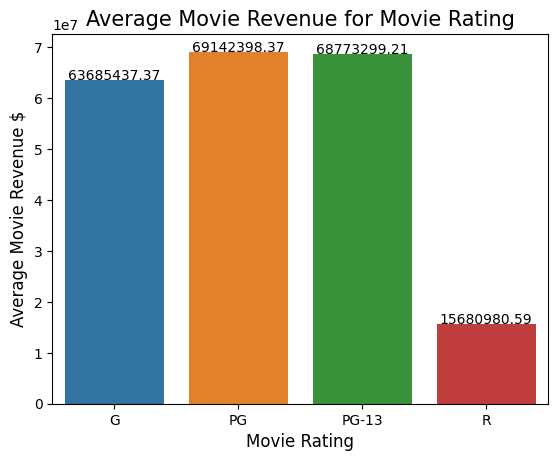

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
def add_labels(x, y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = "center")
certification = df_combined2.groupby("certification")["revenue"].mean().round(2).reset_index()
certification = certification.sort_values(by = "certification")
sns.barplot(data = certification, x = "certification", y = "revenue")
plt.title("Average Movie Revenue for Movie Rating", fontsize = 15)
plt.xlabel("Movie Rating", fontsize = 12)
plt.ylabel("Average Movie Revenue $", fontsize = 12)
add_labels(certification["certification"], certification["revenue"])
plt.show()

### There are three significant differences between ratings all with a p value of less than 0.05. G and R , PG and R, and PG-13 and R all have significant differences in revenue. R rated movies earn the least amount of revenue by a significant margin. The rating that earns the most revenue is PG.

# Question 2:
Do movies that are part of a franchise earn more revenue than movies not in a franchise?

### 
Null Hypothesis: There is no significant difference in revenue between movies that are part of a franchise and not part of a franchise.

Alternative Hypothesis: There is a significant difference in revenue between movies that are part of a franchise and not part of a franchise.

In [14]:
#Seperate movies that are part of a franchise from movies not part of a franchise
df_combined3 = df_combined.copy()
df_combined3["belongs_to_collection"] = df_combined3["belongs_to_collection"].notna()
df_combined3.head()

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
imdb_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,False,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,Two rural teens sing and dance their way throu...,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.500,22.0,NaN
tt0113092,0.0,NaN,False,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,Earth is in a state of constant war and two co...,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.100,8.0,NaN
tt0116391,0.0,NaN,False,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,"After falling prey to underworld, four friends...",...,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,4.000,1.0,NaN
tt0118694,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,False,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",http://www.wkw-inthemoodforlove.com/,843.0,cn,花樣年華,"Hong Kong, 1962: Chow Mo-Wan and Su Li-Zhen mo...",...,12854953.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.112,2009.0,PG


In [15]:
franchise = df_combined3.loc[df_combined3["belongs_to_collection"] == True].copy()
not_franchise = df_combined3.loc[df_combined3["belongs_to_collection"] == False].copy()
franchise_revenue = franchise["revenue"]
non_franchise_revenue = not_franchise["revenue"]

In [16]:
#Drop missing values
non_franchise_revenue.dropna(inplace = True)
non_franchise_revenue.info()

<class 'pandas.core.series.Series'>
Index: 17518 entries, tt0113026 to tt9164254
Series name: revenue
Non-Null Count  Dtype  
--------------  -----  
17518 non-null  float64
dtypes: float64(1)
memory usage: 273.7+ KB


In [17]:
#Checking for outiers in data
zscores = stats.zscore(franchise_revenue)
outliers = abs(zscores) > 3
np.sum(outliers)

40

In [18]:
#Remove outliers from data
franchise_revenue = franchise_revenue[(np.abs(stats.zscore(franchise_revenue) < 3))]

In [19]:
#Checking for outiers in data
zscores = stats.zscore(non_franchise_revenue)
outliers = abs(zscores) > 3
np.sum(outliers)

303

In [20]:
#Remove outliers from data
non_franchise_revenue = non_franchise_revenue[(np.abs(stats.zscore(non_franchise_revenue) < 3))]

In [21]:
#Test the both groups for normality
#Both groups large enough to ignore lack of normal distribution
result_franchise_revenue = stats.normaltest(franchise_revenue)
result_non_franchise_revenue = stats.normaltest(non_franchise_revenue)
print(result_franchise_revenue, result_non_franchise_revenue)

NormaltestResult(statistic=846.7425135923305, pvalue=1.3558116988750227e-184) NormaltestResult(statistic=18509.94069835349, pvalue=0.0)


In [22]:
#Check for equal variance
#Not equal variance include equal var = False
stats.levene(franchise_revenue, non_franchise_revenue)

LeveneResult(statistic=2853.4607228543136, pvalue=0.0)

In [23]:
#Independent t-test with equal_var set to False
stats.ttest_ind(franchise_revenue, non_franchise_revenue, equal_var = False)

Ttest_indResult(statistic=16.181494831641672, pvalue=4.8982611363256514e-54)

### The p value is less than .05, so we reject the null hypothesis and accept there is a significant difference in revenue between movies that are and are not part of franchises.

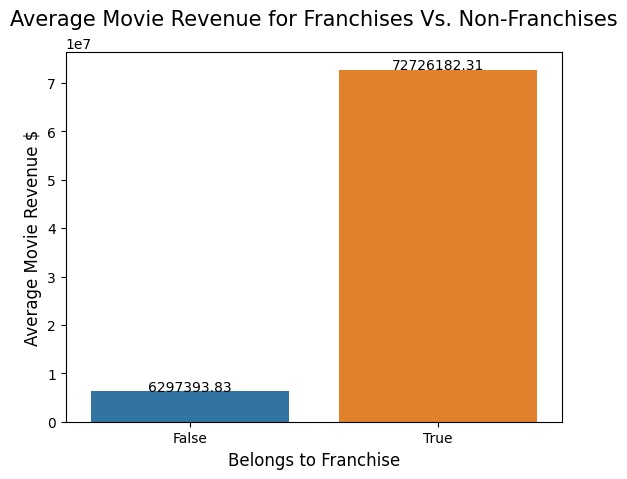

In [24]:
franchise = df_combined3.groupby("belongs_to_collection")["revenue"].mean().round(2).reset_index()
franchise = franchise.sort_values(by = "belongs_to_collection")
sns.barplot(data = franchise, x = "belongs_to_collection", y = "revenue")
plt.title("Average Movie Revenue for Franchises Vs. Non-Franchises", fontsize = 15, y = 1.05)
plt.xlabel("Belongs to Franchise", fontsize = 12)
plt.ylabel("Average Movie Revenue $", fontsize = 12)
add_labels(franchise["belongs_to_collection"], franchise["revenue"])
plt.show()

# Question 3:
Do movies over 2.5 hours earn more revenue than movies shorter than 1.5 hours?

### 
Null Hypothesis: There is no significant difference in revenue between movies with a runtime of over 2.5 hours or less than 1.5 hours.

Alternative Hypothesis: There is a significant difference in revenue between movies with a runtime of over 2.5 hours or less than 1.5 hours.

In [25]:
df_combined4 = df_combined.copy()
df_combined4 = df_combined4[["revenue", "budget", "runtime"]]
df_combined4

,revenue,budget,runtime
imdb_id,,,
0,NaN,NaN,NaN
tt0113026,0.0,10000000.0,86.0
tt0113092,0.0,0.0,100.0
tt0116391,0.0,0.0,152.0
tt0118694,12854953.0,150000.0,99.0
...,...,...,...
tt7657896,0.0,0.0,81.0
tt7851834,0.0,0.0,88.0
tt8090084,0.0,0.0,46.0


In [26]:
#Drop missing values
df_combined4.dropna(inplace = True)

In [27]:
long_movies = df_combined4.loc[df_combined4["runtime"] >= 150].copy()
short_movies = df_combined4.loc[df_combined4["runtime"] <= 90].copy()
long_movie_revenue = long_movies["revenue"]
short_movie_revenue = short_movies["revenue"]

In [28]:
#Checking for outiers in data
zscores = stats.zscore(long_movie_revenue)
outliers = abs(zscores) > 3
np.sum(outliers)

12

In [29]:
#Remove outliers from data
long_movie_revenue = long_movie_revenue[(np.abs(stats.zscore(long_movie_revenue) < 3))]

In [30]:
#Checking for outiers in data
zscores = stats.zscore(short_movie_revenue)
outliers = abs(zscores) > 3
np.sum(outliers)

88

In [31]:
#Remove outliers from data
short_movie_revenue = short_movie_revenue[(np.abs(stats.zscore(short_movie_revenue) < 3))]

In [32]:
#Test the both groups for normality
#Both groups large enough to ignore lack of normal distribution
result_long_movie_revenue = stats.normaltest(long_movie_revenue)
result_short_movie_revenue = stats.normaltest(short_movie_revenue)
print(result_long_movie_revenue, result_short_movie_revenue)

NormaltestResult(statistic=360.8105782057273, pvalue=4.476910749240271e-79) NormaltestResult(statistic=11021.689105442474, pvalue=0.0)


In [33]:
#Check for equal variance
#Not equal variance include equal var = False
stats.levene(long_movie_revenue, short_movie_revenue)

LeveneResult(statistic=561.296456446577, pvalue=4.795662670698461e-120)

In [34]:
#Independent t-test with equal_var set to False
stats.ttest_ind(long_movie_revenue, short_movie_revenue, equal_var = False)

Ttest_indResult(statistic=5.387459219951976, pvalue=1.3057779576274622e-07)

### The p value is less than .05 so we reject the null hypothesis and accept that there is a significant difference in revenue between movie longer than 2.5 hours and shorter than 1.5 hours.

In [35]:
runtime_movies = df_combined4.loc[(df_combined4["runtime"] >= 150) | (df_combined4["runtime"] <= 90)]
for i in runtime_movies["runtime"]:
    if i <= 90:
        runtime_movies["runtime"] = runtime_movies["runtime"].replace(i, "Under 1.5 Hours")
    else:
        runtime_movies["runtime"] = runtime_movies["runtime"].replace(i, "Over 2.5 Hours")
runtime_movies.head()

C:\Users\Antho\AppData\Local\Temp\ipykernel_17328\1713657732.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runtime_movies["runtime"] = runtime_movies["runtime"].replace(i, "Under 1.5 Hours")
C:\Users\Antho\AppData\Local\Temp\ipykernel_17328\1713657732.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runtime_movies["runtime"] = runtime_movies["runtime"].replace(i, "Over 2.5 Hours")


,revenue,budget,runtime
imdb_id,,,
tt0113026,0.0,10000000.0,Under 1.5 Hours
tt0116391,0.0,0.0,Over 2.5 Hours
tt0119273,0.0,15000000.0,Under 1.5 Hours
tt0119495,0.0,0.0,Under 1.5 Hours
tt0120467,14904.0,120000.0,Under 1.5 Hours


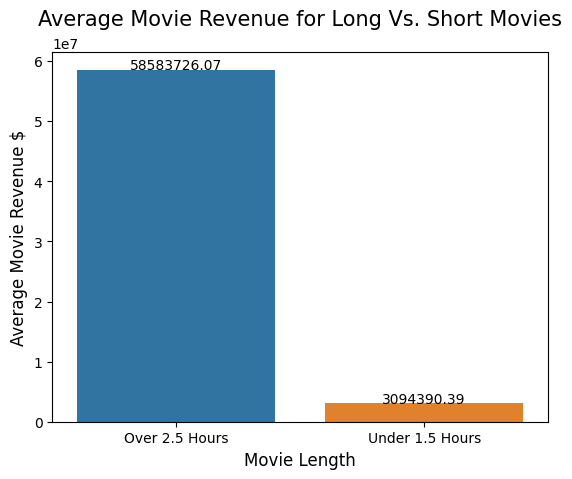

In [36]:
runtime = runtime_movies.groupby("runtime")["revenue"].mean().round(2).reset_index()
runtime = runtime.sort_values(by = "runtime")
sns.barplot(data = runtime, x = "runtime", y = "revenue")
plt.title("Average Movie Revenue for Long Vs. Short Movies", fontsize = 15, y = 1.05)
plt.xlabel("Movie Length", fontsize = 12)
plt.ylabel("Average Movie Revenue $", fontsize = 12)
add_labels(runtime["runtime"], runtime["revenue"])
plt.show()